# 기본 설정

In [2]:
import os
gpu_number = '0'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_number

import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL 

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# root: 현재 폴더
ROOT_DIR = os.path.abspath("./")
sys.path.append(ROOT_DIR) 

# model 들어있는 폴더
MODEL_DIR = os.path.join(ROOT_DIR, "models", "badminton_200(shoes).h5") # mylogs에 최종 모델 넣어놔야 함.

<br />

# 사용자 조정 필요

In [3]:
import badminton
config = badminton.CocoConfig() # 기본 설정들. hyperparameter

DATA_DIR = "/home/joon/dataset"  # TODO: enter value here
model_name = "badminton_200(shoes).h5" #"emo_frame_E01-E24_201020.h5"

<br />

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

DEVICE = "/gpu:{}".format(gpu_number)  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

dataset = badminton.CocoDataset()
dataset.load_coco(DATA_DIR, "test") # test로 바꾸기

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Images: 20
Classes: ['BG', 'player', 'shoes']


<br />

# inference 모드로 모델 불러오기

In [5]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Load weights
model_path = os.path.join(MODEL_DIR)

print("Loading weights ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights  /mnt/c/users/korea/documents/mask-rcnn/models/badminton_200(shoes).h5


<br />

# model test

1


'\nvisualize.draw_boxes(original_image, boxes=r[\'rois\'], refined_boxes=None,\n                     masks=None, captions=None, visibilities=None,\n                     title="FACE", ax=ax)\n'

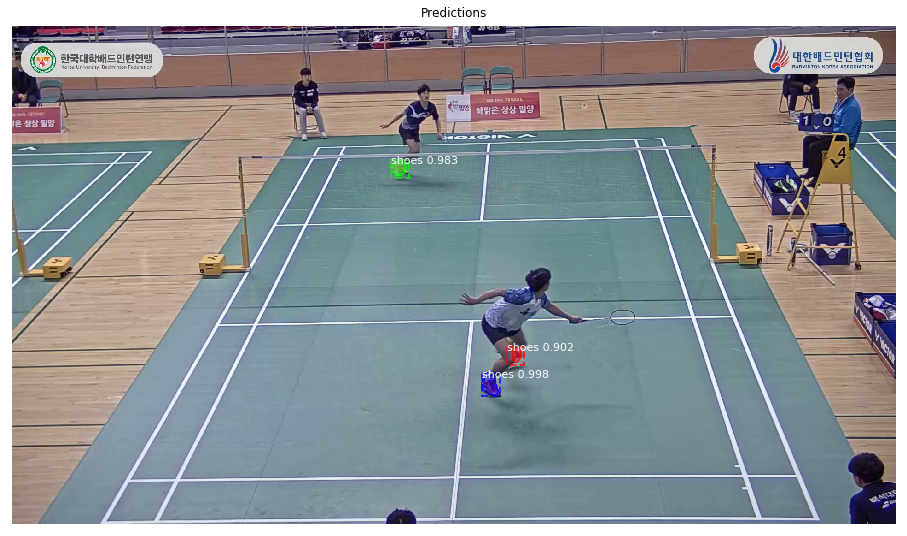

In [31]:
import skimage

image_path = "/home/joon/dataset/test/{}".format('000020.jpg') # 아무 사진이나 테스트 하는 부분

original_image = skimage.io.imread(image_path)

#original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, 101, use_mini_mask=False)
# If grayscale. Convert to RGB for consistency.
if original_image.ndim != 3:
    original_image = skimage.color.gray2rgb(original_image)

# Run object detection
results = model.detect([original_image], verbose=0)

# Display results
ax = get_ax(1)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
'''
visualize.draw_boxes(original_image, boxes=r['rois'], refined_boxes=None,
                     masks=None, captions=None, visibilities=None,
                     title="FACE", ax=ax)
'''
#print (r)

<br />

### Test

In [7]:
mAPs = []
started = time.time()
print ('model : {}'.format(model_name))
for image_id in range(len(dataset.image_ids)):
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    test_result = utils.compute_ap(gt_boxes=gt_bbox, gt_class_ids=gt_class_id, gt_masks=gt_mask, 
                                   pred_boxes=r['rois'], pred_class_ids=r['class_ids'], 
                                   pred_scores=r['scores'], pred_masks=r['masks'], 
                                   iou_threshold=0.5)
    
    mAP, precision, recall, overlap = test_result[0], test_result[1], test_result[2], test_result[3]
    mAPs.append(mAP)
    
    if image_id % 10 == 0:
        print ('{}, elapsed : {:.3}m'.format(image_id, (time.time()-started)/60))


model : badminton_200(shoes).h5
1
0, elapsed : 0.0554m
1
1
1
1
1
1
1
1
1
1
10, elapsed : 0.607m
1
1
1
1
1
1
1
1
1


### Test results

In [8]:
badminton_300_mAP = sum(mAPs)/len(mAPs)
badminton_300_mAP

0.40381944676240283

<br />

<br />

## Detection and make gt & dr

### 수정해야할 부분

In [15]:
model_name

'badminton_100.h5'

In [21]:
root_dir = '/home/joon/dataset'
gt_save_path = os.path.join(root_dir, 'ground_truth')
dr_save_path = os.path.join(root_dir, 'detection_results', '{}'.format(model_name[:-3]))
if not os.path.isdir(gt_save_path):
    os.mkdir(gt_save_path)
if not os.path.isdir(dr_save_path):
    os.makedirs(dr_save_path)

In [22]:
data_root_dir = '/home/joon/dataset'
data_dir = os.path.basename(DATA_DIR)

In [23]:
data_dir

'dataset'

### json files & class ids

In [24]:
import json

test_data_path = os.path.join(DATA_DIR, 'test')
annotations_path = os.path.join(DATA_DIR, 'annotations')
test_anno_path = os.path.join(annotations_path, 'instances_test.json')
train_anno_path = os.path.join(annotations_path, 'instances_train.json')
val_anno_path = os.path.join(annotations_path, 'instances_val.json')

loaded = json.load(open(test_anno_path))
class_ids_info = {i['id']:i['name'] for i in loaded['categories'] }
print (class_ids_info)

{1: 'player', 2: 'racket'}


### Ground-truth (Mask RCNN -> YOLO)

In [25]:
matched = {}
for label_info in loaded['annotations']:
    cate_id = label_info['category_id']
    class_ = class_ids_info[cate_id]
    img_id = label_info['image_id']
    img_name = loaded['images'][img_id-1]['file_name']
    bbox = label_info['bbox']
    class_n_bbox = [class_, str(int(bbox[0])), str(int(bbox[1])), str(int(bbox[0])+int(bbox[2])), str(int(bbox[1])+int(bbox[3]))]
    if img_name not in matched:
        matched[img_name] = [class_n_bbox]
    else:
        matched[img_name].append(class_n_bbox)

for img, gt_bboxes_info in matched.items():
    gt_file_name = img.replace('jpg', 'txt')
    gt_file_path = os.path.join(gt_save_path, gt_file_name)
    writing = '\r\n'.join([' '.join(gbi) for gbi in gt_bboxes_info ])
    with open(gt_file_path, 'w') as f:
        f.write(writing)

### Detection results (Mask RCNN -> YOLO)

In [26]:
import cv2

started = time.time()
for i, image_name in enumerate([f for f in sorted(os.listdir(test_data_path)) if 'jpg' in f]):
    
    image_path = os.path.join(test_data_path, image_name)
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Run object detection
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    writing = []
    for roi, c_id, score in zip(r['rois'], r['class_ids'], r['scores']):
        writing.append(' '.join([class_ids_info[c_id], 
                                 str(score), str(int(roi[1])), str(int(roi[0])), str(int(roi[3])), str(int(roi[2]))]))
    
    write_input = '\r\n'.join(writing)
    save_path = os.path.join(dr_save_path, image_name.replace('jpg', 'txt'))
    
    with open(save_path, 'w') as f:
        f.write(write_input)
    
    if i % 10 == 0:
        print ('{}, elapsed : {:.3}m'.format(i, (time.time()-started)/60))

1
0, elapsed : 0.174m
1
1
1
1
1
1
1
1
1
1
10, elapsed : 2.05m
1
1
1
1
1
1
1
1
1
1
20, elapsed : 3.81m
1
1
1
1
1
1
1
1
1
1
30, elapsed : 5.71m
1
1
1
1
1
1
1
1
1
1
40, elapsed : 7.59m
1
1
1
1
1
1
1
1
1
1
50, elapsed : 9.37m
1
1
1
1
1
1
1
1
1


### detect and save bbox to image

In [76]:
import PIL 
import cv2
import time

score_threshold = 0.7
fps = 10

emo_image_path = '/home/joon/dataset/test'
#episode_root_path = os.path.join(emo_image_path, 'mfE01_E24_fps{}'.format(fps))
print(emo_image_path)
'''
episode_dir = 'mfE01_fps{}'.format(fps)
episode_path = os.path.join(episode_root_path, episode_dir)

if not os.path.isdir(episode_path): os.mkdir(episode_path)
detected_path = os.path.join(emo_image_path, 'Detection_Cropping', '{}_detected_{}_{}_fps{}'.format(episode_dir[2:5], model_name[18:-3], score_threshold, fps))
if not os.path.isdir(detected_path): os.mkdir(detected_path)
'''

/home/joon/dataset/test


"\nepisode_dir = 'mfE01_fps{}'.format(fps)\nepisode_path = os.path.join(episode_root_path, episode_dir)\n\nif not os.path.isdir(episode_path): os.mkdir(episode_path)\ndetected_path = os.path.join(emo_image_path, 'Detection_Cropping', '{}_detected_{}_{}_fps{}'.format(episode_dir[2:5], model_name[18:-3], score_threshold, fps))\nif not os.path.isdir(detected_path): os.mkdir(detected_path)\n"

In [88]:
id_class_matched = {1: 'player', 2: 'racket' }

def cropsizer(image, bboxs):
    image = PIL.Image.open(image) 

    for bound in bboxs:
        np_image = np.asarray( image.crop(bound) ) 

    return np_image, bboxs

'''
######################################################
started = time.time()
for episode_dir in sorted(os.listdir(emo_image_path)):
    
    episode_path = os.path.join(emo_image_path, episode_dir)
    if not os.path.isdir(episode_path): 
        os.mkdir(episode_path)
        
    detected_path = os.path.join(emo_image_path, 'Detection_Cropping', 
                                 '{}_detected_{}_{}_fps{}'.format(episode_dir[2:5], model_name[18:-3], score_threshold, fps))
    
    if not os.path.isdir(detected_path): 
        os.mkdir(detected_path)
######################################################
'''
        
    #started = time.time()
for i, img_file in enumerate([f for f in sorted(os.listdir(emo_image_path)) if 'jpg' in f]):

    image_path = os.path.join(emo_image_path, img_file)
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    detected_path = os.path.join(emo_image_path, 'Detection_Cropping', )
    
    if not os.path.isdir(detected_path): 
        os.mkdir(detected_path)

    if len(r['rois']) >= 1:
        for roi, c_id, score in zip(r['rois'], r['class_ids'], r['scores']):
            if score >= score_threshold:
                bbox_ = np.array([[roi[1], roi[0],roi[3],roi[2]]])
                result, _ = cropsizer(image_path, bbox_)
                result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                detected = id_class_matched[c_id]
                detected_save_path = os.path.join(detected_path, '{}_{}.jpg'.format(img_file[:-4], detected))
                cv2.imwrite(detected_save_path, result)

        #if i%100 == 0:
            #print ('{}, elapsed : {:.3}m'.format(i, (time.time()-started)/60))
print ('{}, elapsed : {:.3}m'.format(episode_dir[2:5], (time.time()-started)/60))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
000, elapsed : 20.8m


<br />

<br />

<br />

### YOLO v2 test score

In [27]:
import os
import cv2
from lxml import etree
import xml.etree.cElementTree as ET
from xml.etree.cElementTree import parse
import json
import time

root_dir = '/home/joon/dataset'
yolo_dr_path = os.path.join(root_dir, 'detection_results','badminton_100')
yolo_gt_path = os.path.join(root_dir, 'ground_truth')


In [28]:
loaded = json.load(open('/home/joon/dataset/test_option.json'))
categories = loaded['CATEGORIES']
categories_list = {i['name']:i['id'] for i in categories}
categories_list

{'player': 1, 'racket': 2}

In [29]:
mAPs, precisions, recalls, overlaps = [],[],[],[]
started = time.time()

for image_id, (dr_txt, gt_txt) in enumerate(zip(sorted(os.listdir(yolo_dr_path)), [f for f in sorted(os.listdir(yolo_gt_path)) if 'txt' in f])):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    dr_txt_path = os.path.join(yolo_dr_path, dr_txt)
    gt_txt_path = os.path.join(yolo_gt_path, gt_txt)
    
    with open(dr_txt_path, 'r') as f:
        detected_list = f.readlines()
        if len(detected_list) == 0:
            r['rois'] = np.empty((0,4)).astype(np.int32)
            r['class_ids'] = np.empty((0)).astype(np.int32)
            r['masks'] = np.empty((720,1280,0)).astype(np.float64)
            r['scores'] = np.empty((0)).astype(np.float32)
        else:
            detected_list = [dl.replace('\n', '') for dl in detected_list]
            r['rois'] = np.array([[int(i.split(' ')[3]), int(i.split(' ')[2]), 
                                   int(i.split(' ')[5]), int(i.split(' ')[4])] for i in detected_list])
            r['class_ids'] = np.array([categories_list[i.split(' ')[0]] for i in detected_list])
        
    with open(gt_txt_path, 'r') as f:
        gt_list = f.readlines()
        gt_list = [gt.replace('\n', '') for gt in gt_list]
        gt_bbox =  np.array([[int(i.split(' ')[2]), int(i.split(' ')[1]), 
                              int(i.split(' ')[4]), int(i.split(' ')[3])] for i in gt_list])
        gt_class_id = np.array([categories_list[i.split(' ')[0]] for i in gt_list])
        
#    print (r['rois'], ' vs ', gt_bbox)
#    print (r['class_ids'], ' vs ', gt_class_id)
#    print ('-'*100)

    test_result = utils.compute_ap(gt_boxes=gt_bbox, gt_class_ids=gt_class_id, gt_masks=gt_mask, 
                                   pred_boxes=r['rois'], pred_class_ids=r['class_ids'], pred_scores=r['scores'], 
                                   pred_masks=r['masks'], iou_threshold=0.5)
    mAP, precision, recall, overlap = test_result[0], test_result[1], test_result[2], test_result[3]
    mAPs.append(mAP)
    
    if image_id % 10 == 0:
        print ('{}, elapsed : {:.3}m'.format(image_id, (time.time()-started)/60))


1
0, elapsed : 0.216m
1
1
1
1
1
1
1
1
1
1
10, elapsed : 1.99m
1
1
1
1
1
1
1
1
1
1
20, elapsed : 3.85m
1
1
1
1
1
1
1
1
1
1
30, elapsed : 5.7m
1
1
1
1
1
1
1
1
1
1
40, elapsed : 7.54m
1
1
1
1
1
1
1
1
1
1
50, elapsed : 9.32m
1
1
1
1
1
1
1
1
1


In [30]:
yolov2_mAP = sum(mAPs)/len(mAPs)
yolov2_mAP

0.9666666666666667